In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from pathlib import Path
import keras
from keras import layers
import matplotlib.pyplot as plt
import shutil
import random
import pathlib
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ruta_datos = "/content/drive/MyDrive/Entrenamientos DL COA 690/Nuevos datos/Conjunto Completo.zip"
ruta_salida = "/content/"
!unzip -qq "{ruta_datos}" -d "{ruta_salida}"

In [4]:
original_dir = pathlib.Path("/content/Conjunto Completo")
new_base_dir = pathlib.Path("/content/")
classes = ["A", "R", "S"]

train_split = 0.70
val_split = 0.10
test_split = 0.20

for category in classes:
    print(f"Processing {category} images...")

    # Get the filenames for the current category
    fnames = [fname for fname in os.listdir(original_dir) if fname.startswith(category)]

    # Get the total number of images
    n_images = len(fnames)

    # Shuffle the filenames randomly
    np.random.seed(1)
    np.random.shuffle(fnames)

    # Calculate the number of images for each set
    n_train = int(train_split * n_images)
    n_val = int(val_split * n_images)
    n_test = n_images - n_train - n_val

    # Split the filenames into sets
    train_fnames = fnames[:n_train]
    val_fnames = fnames[n_train:n_train+n_val]
    test_fnames = fnames[n_train+n_val:]

    # Create the directories for the sets
    train_dir = new_base_dir / "train" / category
    val_dir = new_base_dir / "validation" / category
    test_dir = new_base_dir / "test" / category

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Copy the images to the corresponding directories
    for fname in train_fnames:
        src_path = original_dir / fname
        dst_path = train_dir / fname
        shutil.copyfile(src_path, dst_path)

    for fname in val_fnames:
        src_path = original_dir / fname
        dst_path = val_dir / fname
        shutil.copyfile(src_path, dst_path)

    for fname in test_fnames:
        src_path = original_dir / fname
        dst_path = test_dir / fname
        shutil.copyfile(src_path, dst_path)

print("Done.")


Processing A images...
Processing R images...
Processing S images...
Done.


In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(224, 224),
    batch_size=32,
    label_mode = 'categorical')
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(224, 224),
    batch_size=16,
    label_mode = 'categorical')
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(224, 224),
    batch_size=16,
    label_mode = 'categorical',
    shuffle = False)

Found 467 files belonging to 3 classes.
Found 65 files belonging to 3 classes.
Found 137 files belonging to 3 classes.


In [6]:
data_augmentation = keras.Sequential(
        [
            layers.RandomRotation(random.uniform(0, 0.2)),
            layers.RandomZoom(random.uniform(0.1, 0.3)),
            layers.RandomContrast(random.uniform(0.1, 0.3)),
            layers.RandomBrightness(random.uniform(0.1, 0.3)),
            layers.RandomWidth(factor=random.uniform(0.1, 0.3)),
            layers.RandomHeight(factor=random.uniform(0.1, 0.3)),
            layers.RandomCrop(height=200, width=200),
            layers.RandomTranslation(height_factor=random.uniform(0, 0.1),
                                      width_factor=random.uniform(0, 0.1)),
            layers.RandomFlip("horizontal")
        ]
)

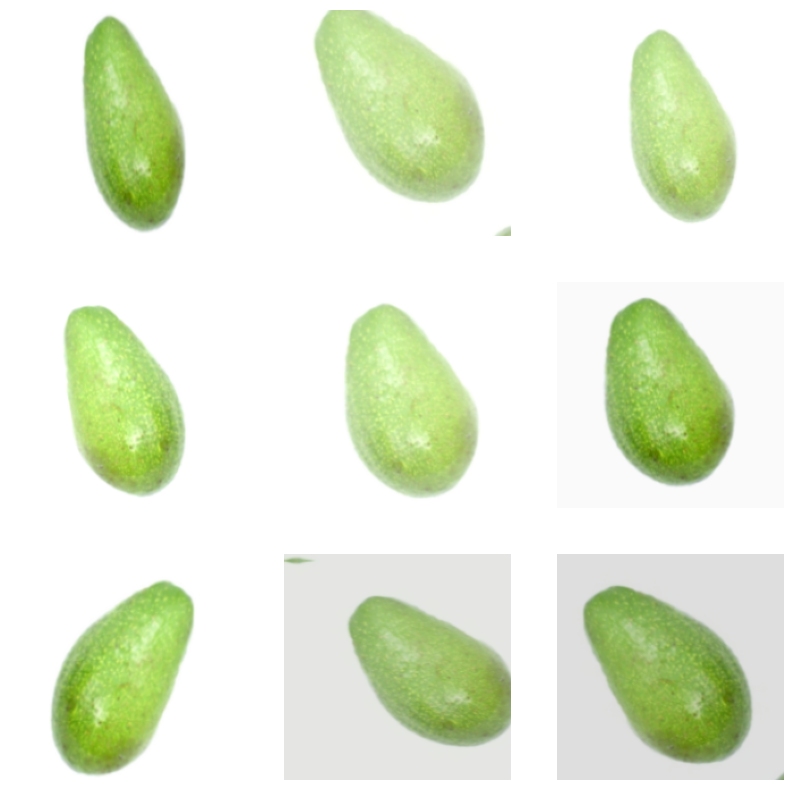

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False
)

conv_base.trainable = True
for layer in conv_base.layers[-4:]:
  layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [9]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 200, 200, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                             

In [11]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adamax(learning_rate = 0.001),
              metrics = ['accuracy'])

In [12]:
callbacks = [
    ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor='val_accuracy'
    ),
    EarlyStopping(
        monitor = 'val_accuracy',
        patience = 20
    )
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 20s 282ms/step - loss: 9.0572 - accuracy: 0.3169 - val_loss: 1.1472 - val_accuracy: 0.4308
Epoch 2/100
15/15 [==============================] - 1s 57ms/step - loss: 1.3161 - accuracy: 0.3747 - val_loss: 1.1905 - val_accuracy: 0.2615
Epoch 3/100
15/15 [==============================] - 1s 56ms/step - loss: 1.1589 - accuracy: 0.4133 - val_loss: 1.0204 - val_accuracy: 0.3538
Epoch 4/100
15/15 [==============================] - 1s 83ms/step - loss: 1.1125 - accuracy: 0.4561 - val_loss: 0.9561 - val_accuracy: 0.6000
Epoch 5/100
15/15 [==============================] - 1s 56ms/step - loss: 1.0217 - accuracy: 0.5032 - val_loss: 0.9406 - val_accuracy: 0.5846
Epoch 6/100
15/15 [==============================] - 1s 83ms/step - loss: 0.9547 - accuracy: 0.5546 - val_loss: 0.8635 - val_accuracy: 0.6154
Epoch 7/100
15/15 [==============================] - 2s 141ms/step - loss: 0.9384 - accuracy: 0.5824 - val_loss: 0.8434 - val_accuracy: 0.6615
Epo

In [13]:
best_val_acc = callbacks[0].best
best_epoch = np.argmax(history.history['val_accuracy']) + 1

print("Mejor época: ", best_epoch)
print("Val Acc de la mejor época: {:.2f}".format(best_val_acc))

Mejor época:  32
Val Acc de la mejor época: 0.86


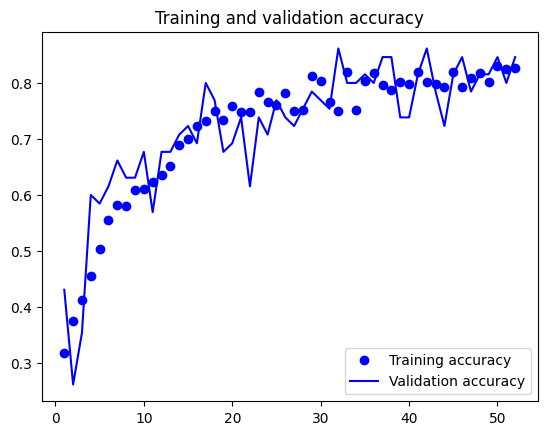

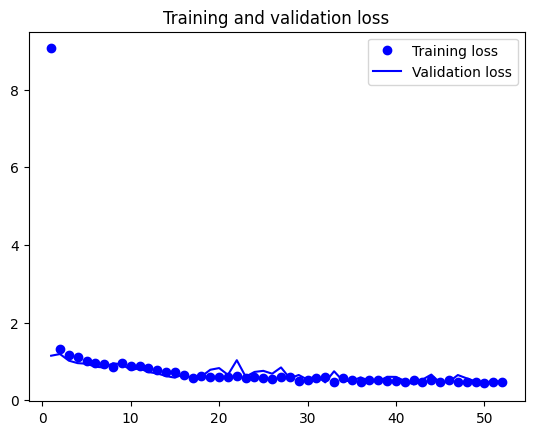

In [14]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [20]:
ruta_modelos = "/content/drive/MyDrive/Entrenamientos DL COA 690/Nuevos datos/Modelos optimizados/"
os.chdir(ruta_modelos)
test_model = keras.models.load_model("/content/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

test_model.save("VGG16.keras")

9/9 [==============================] - 1s 56ms/step - loss: 0.7353 - accuracy: 0.7372
Test accuracy: 0.737


In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

test_predictions = test_model.predict(test_dataset)
test_labels = np.concatenate([labels for _, labels in test_dataset], axis=0)
test_labels = np.argmax(test_labels, axis=1)

9/9 [==============================] - 0s 12ms/step


In [22]:
# Obtener las clases predichas
predicted_classes = np.argmax(test_predictions, axis=1)

# Generar el informe de clasificación
classification_rep = classification_report(test_labels, predicted_classes)
print(classification_rep)


              precision    recall  f1-score   support

           0       0.59      0.70      0.64        37
           1       0.84      0.66      0.74        41
           2       0.79      0.81      0.80        59

    accuracy                           0.74       137
   macro avg       0.74      0.72      0.73       137
weighted avg       0.75      0.74      0.74       137



In [23]:
test_accuracy = accuracy_score(test_labels, predicted_classes)

print("Precisión en el conjunto de prueba: {:.2f}%".format(test_accuracy * 100))

Precisión en el conjunto de prueba: 73.72%


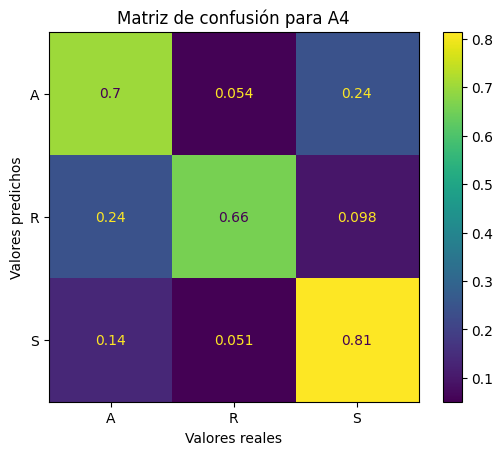

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Calcula la matriz de confusión
confusion = confusion_matrix(test_labels, predicted_classes, normalize = 'true')

display = ConfusionMatrixDisplay(confusion_matrix = confusion,
                                 display_labels = classes)

fig, ax = plt.subplots()
display.plot(ax=ax)
ax.set_title("Matriz de confusión para A4")
ax.set_xlabel("Valores reales")
ax.set_ylabel("Valores predichos")
plt.show()